In [40]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client
client = Client(tld='us')

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

In [41]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
r = client.get_historical_klines('BTCUSDT','1h',startDate)

In [42]:
df = pd.DataFrame(r)
colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)
df['predict'] = 1
df.set_index("closeTime", inplace= True)
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict
closeTime,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,46192.43,46715.27,46192.43,46670.23,17.363974,806563.32129247,543,12.21561800,567219.24202502,0,NaN,0.002362,1
2022-01-01 01:59:59.999,1640998800000,46643.41,46932.99,46564.34,46780.47,6.799312,317924.86514860,336,2.05007400,96019.16970575,0,0.002362,-0.000093,1


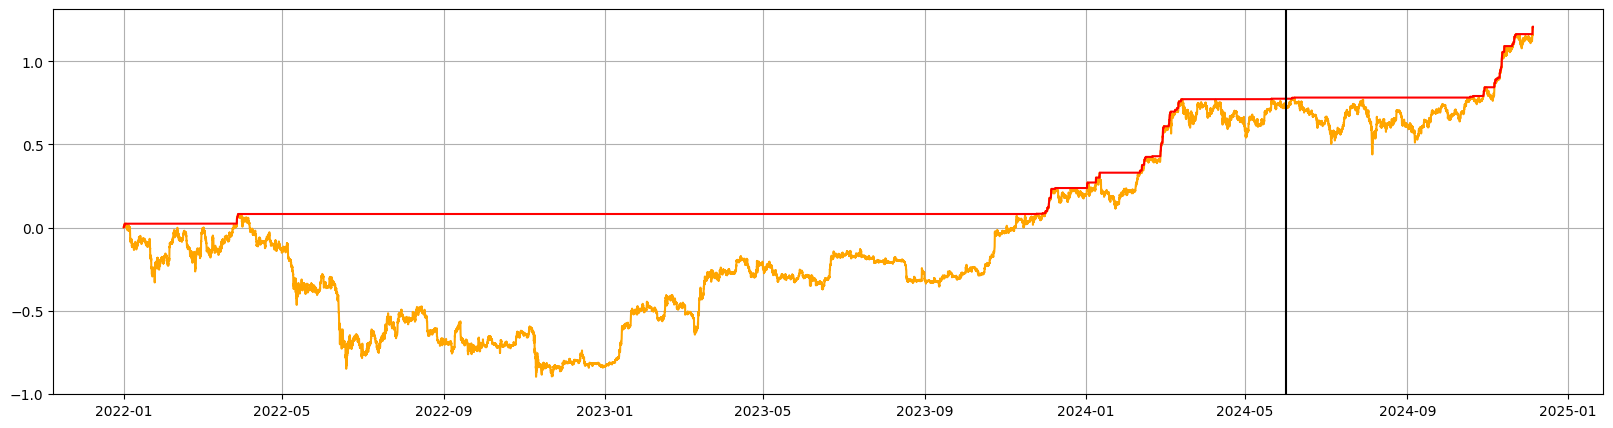

In [43]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [44]:
def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe      : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train

In [45]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)

    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.

    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/

    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal

        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
            Histogram = MA

In [46]:
df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
closeTime,,,
2022-01-01 00:59:59.999,NaN,NaN,NaN
2022-01-01 01:59:59.999,NaN,NaN,NaN
2022-01-01 02:59:59.999,NaN,NaN,NaN
2022-01-01 03:59:59.999,NaN,NaN,NaN
2022-01-01 04:59:59.999,NaN,NaN,NaN
...,...,...,...
2024-12-05 03:59:59.999,1219.883219,571.046555,648.836664
2024-12-05 04:59:59.999,1491.771751,674.348070,817.423681
2024-12-05 05:59:59.999,1616.008274,638.867674,977.140600


In [47]:
df.dtypes

openTime              int64
openPrice           float64
highPrice           float64
lowPrice            float64
closePrice          float64
volume              float64
quoteAssetVolume     object
NumberOfTrades        int64
TakerBaseVolume      object
TakerQuoteVolume     object
Ignore               object
return              float64
return_next         float64
predict               int64
pnl                 float64
pnl_cumsum          float64
pnl_cumsum_max      float64
pnl_dd              float64
MACD_12_26_9        float64
MACDh_12_26_9       float64
MACDs_12_26_9       float64
dtype: object

In [48]:
columns_to_convert = ['quoteAssetVolume', 'TakerBaseVolume', 'TakerQuoteVolume', 'Ignore']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [49]:
def func_features(df):
    for length in [6, 12, 16, 20, 25, 30, 50]:
        # Simple Moving Average (SMA) and related signal
        df.ta(kind='SMA', append=True, centered=False, close='closePrice', length=length)
        df[f'f_SMA_{length}'] = np.where(df['closePrice'] > df[f'SMA_{length}'], -1, 1)

        # Trend-based feature using rolling returns
        df[f'f_trend_{length}'] = np.where(df['return'].rolling(window=length).sum() > 0, -1, 1)

        # Average True Range (ATR)
        df.ta(kind='ATR', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=length)
        df[f'f_ATR_{length}'] = np.where(df[f'ATRr_{length}'] > df[f'ATRr_{length}'].rolling(window=6).mean(), 1, -1)

        # Relative Strength Index (RSI)
        df.ta(kind='RSI', append=True, centered=False, close='closePrice', length=length)
        df[f'f_RSI_{length}'] = np.where(df[f'RSI_{length}'] < 20, 1, np.where(df[f'RSI_{length}'] > 80, -1, 0))

        # Price Volume Trend (PVT)
        df.ta(kind='PVT', append=True, centered=False, volume='volume', close='closePrice')
        df[f'f_PVT_{length}'] = np.where(df['PVT'] > df['PVT'].rolling(window=length).mean(), 1, -1)

        # Bollinger Bands
        df.ta(kind='BBANDS', append=True, centered=False, close='closePrice', length=length)
        df[f'f_bb_{length}_low'] = np.where(df['closePrice'] < df[f'BBL_{length}_2.0'], 1, 0)
        df[f'f_bb_{length}_high'] = np.where(df['closePrice'] > df[f'BBU_{length}_2.0'], -1, 0)

    # Moving Average Convergence Divergence (MACD)
    df.ta(kind='MACD', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_macd'] = np.where(df['MACDh_12_26_9'] > 0, 1, -1)

    # On-Balance Volume (OBV)
    df.ta(kind='OBV', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_OBV'] = np.where(df['OBV'] < df['OBV'].rolling(window=12).mean(), -1, 1)

    # Momentum Indicator (MOM)
    df.ta(kind='MOM', append=True, centered=False, close='closePrice', length=10)
    df['f_momentum'] = np.where(df['MOM_10'] > 0, 1, -1)

    # Additional features
    df['f_high'] = df['highPrice'].pct_change().fillna(0)
    df['f_low'] = df['lowPrice'].pct_change().fillna(0)
    df['f_high_low'] = (df['highPrice'] - df['lowPrice']) / (df['highPrice'] + df['lowPrice']).fillna(0)
    df['f_open_close'] = (df['openPrice'] - df['closePrice']) / (df['openPrice'] + df['closePrice']).fillna(0)
    df['f_ntv'] = df['NumberOfTrades'].pct_change().where(df['NumberOfTrades'].pct_change() != np.inf, np.nan).ffill().fillna(0)
    df['f_taker_volume_ratio'] = (df['TakerBaseVolume'] / df['volume']).fillna(0)
    df['f_rolling_std'] = df['closePrice'].rolling(window=20).std().fillna(0)

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f'lag_return_{lag}'] = df['return'].shift(lag)

    # Feature engineering for targets
    df['return_next_class'] = np.where(df['return_next'] > 0, 1, 0)

    return df

In [50]:
df = func_features(df)

In [51]:
def func_train_model(modelType,df,testDate):

  if modelType == 'cb':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = CatBoostRegressor(loss_function='RMSE',depth=15, verbose=False, early_stopping_rounds=10)
    model.fit(X_train,y_train)

  if modelType == 'lr':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)

  if modelType == 'lr_ig':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']

    #mutual_info = mutual_info_regression(X_train,y_train)
    #mutual_info = pd.Series(mutual_info)
    #mutual_info.index = features
    #mutual_info.sort_values(ascending=False)

    bestCols =  SelectKBest(mutual_info_regression,k=10)
    bestCols.fit(X_train,y_train)
    features = list(X_train.columns[bestCols.get_support()])

    X_train = train[features]
    model = LinearRegression()
    model.fit(X_train,y_train)

  if modelType == 'lr_rfe':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    reg = LinearRegression()
    model = RFE(reg, n_features_to_select=15)
    model.fit(X_train,y_train)
  if modelType == 'lr_reg':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = Ridge(alpha=1.0)
    model.fit(X_train,y_train)
  if modelType == 'lr_cor':
    features = [col for col in df if col.startswith('f_')]
    corr_matrix = df[features].corr().abs()
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k =1).astype(np.bool_))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
    features = [f for f in features if f not in to_drop]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
  if modelType == 'dt':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next_class']
    model = DecisionTreeClassifier(random_state=0,max_depth=5)
    model.fit(X_train,y_train)
  if modelType == 'elnet':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    alpha = [0.0001,0.001,0.1,1,10,100]
    max_iter = [1000,10000]
    l1_ratio = np.arange(0.0,1.0,0.1)
    tol=[0.5]
    elnet_gscv = GridSearchCV(estimator=ElasticNet(),param_grid={'alpha':alpha,'max_iter':max_iter,'l1_ratio':l1_ratio,'tol':tol}, scoring='r2',cv=5)
    elnet_gscv.fit(X_train,y_train)
    model = ElasticNet(alpha = elnet_gscv.best_params_['alpha'],
                      max_iter = elnet_gscv.best_params_['max_iter'],
                      l1_ratio = elnet_gscv.best_params_['l1_ratio'],
                      tol = elnet_gscv.best_params_['tol'])
    model.fit(X_train,y_train)

  df['predict'] = model.predict(df[features])
  df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  df['pnl'] = df['predict'] * df['return_next']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  return df
df = func_train_model('lr_reg',df,testDate)

            train     test
PNL      : 5.96985    0.810052  
MDD      : 0.32466    0.216537  
Sharpe      : 18.388006  3.74094   


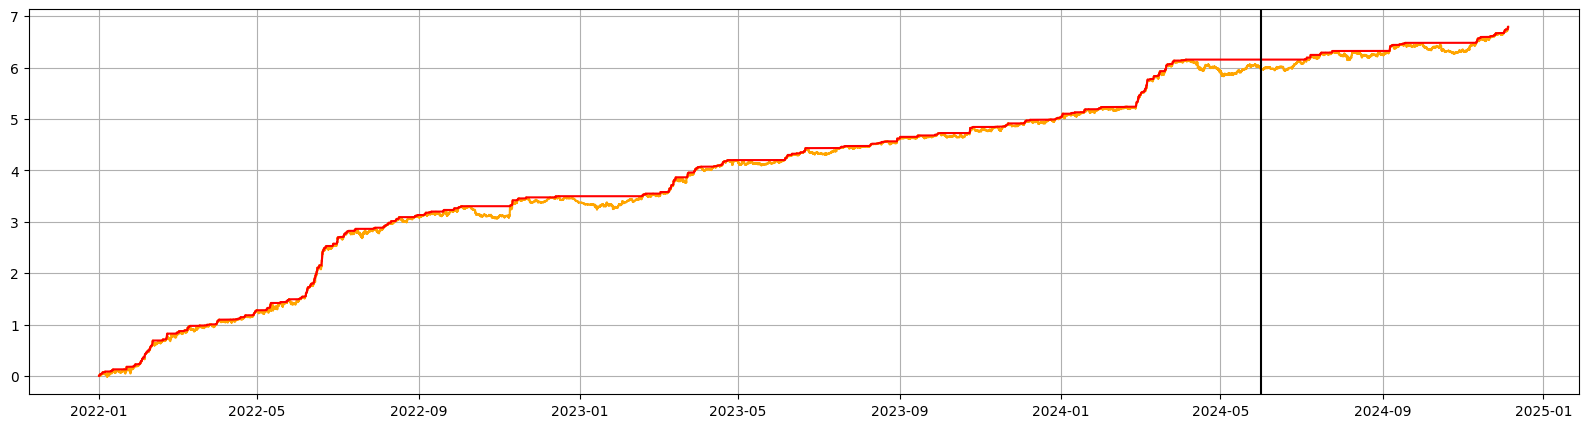

In [52]:
sharpe = func_model_performance(df)
func_plot(df)

In [53]:
import optuna
from functools import partial

def objective(trial, testDate=testDate, df=df):

  #length_rsi = int(trial.suggest_categorical("length_rsi",["6","12","18","24","30","36"]))
  #length_pvt = int(trial.suggest_categorical("length_pvt",["6","12","18","24","30","36"]))
  model_type = trial.suggest_categorical("model_type",["lr","dt","lr_reg","lr_cor","lr_rfe","elnet","lr_ig","cb"])

  df = func_features(df)
  df = func_train_model(model_type,df,testDate)
  sharpe = func_model_performance(df)

  return sharpe

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 20, timeout = 1000, show_progress_bar = True)

[I 2024-12-05 10:36:44,385] A new study created in memory with name: no-name-16c6b7c5-8d07-4599-9559-e47073b7cf0a
Best trial: 0. Best value: 0.983053:   5%|▌         | 1/20 [00:05<01:37,  5.15s/it, 5.15/1000 seconds]

            train     test
PNL      : 0.957404   0.257621  
MDD      : 0.973909   0.972281  
Sharpe      : 0.983053   0.264966  
[I 2024-12-05 10:36:49,536] Trial 0 finished with value: 0.983053 and parameters: {'model_type': 'lr_ig'}. Best is trial 0 with value: 0.983053.


Best trial: 1. Best value: 6.74146:  10%|█         | 2/20 [00:06<00:48,  2.71s/it, 6.15/1000 seconds] 

            train     test
PNL      : 2.322755   0.430669  
MDD      : 0.344548   0.333564  
Sharpe      : 6.741455   1.291114  
[I 2024-12-05 10:36:50,530] Trial 1 finished with value: 6.741455 and parameters: {'model_type': 'lr_rfe'}. Best is trial 1 with value: 6.741455.


Best trial: 2. Best value: 16.0961:  15%|█▌        | 3/20 [00:06<00:27,  1.62s/it, 6.48/1000 seconds]

            train     test
PNL      : 4.594948   0.667149  
MDD      : 0.28547    0.257399  
Sharpe      : 16.09608   2.591887  
[I 2024-12-05 10:36:50,865] Trial 2 finished with value: 16.09608 and parameters: {'model_type': 'lr_cor'}. Best is trial 2 with value: 16.09608.


Best trial: 2. Best value: 16.0961:  20%|██        | 4/20 [00:06<00:17,  1.10s/it, 6.79/1000 seconds]

            train     test
PNL      : 1.929031   0.303004  
MDD      : 0.300714   0.286138  
Sharpe      : 6.414836   1.058944  
[I 2024-12-05 10:36:51,171] Trial 3 finished with value: 6.414836 and parameters: {'model_type': 'dt'}. Best is trial 2 with value: 16.09608.


Best trial: 2. Best value: 16.0961:  25%|██▌       | 5/20 [00:07<00:16,  1.07s/it, 7.79/1000 seconds]

            train     test
PNL      : 2.322755   0.430669  
MDD      : 0.344548   0.333564  
Sharpe      : 6.741455   1.291114  
[I 2024-12-05 10:36:52,179] Trial 4 finished with value: 6.741455 and parameters: {'model_type': 'lr_rfe'}. Best is trial 2 with value: 16.09608.


Best trial: 5. Best value: 38949.2:  30%|███       | 6/20 [10:07<47:46, 204.75s/it, 607.93/1000 seconds]

            train     test
PNL      : 74.04251   0.924013  
MDD      : 0.001901   0.258356  
Sharpe      : 38949.242504 3.576511  
[I 2024-12-05 10:46:52,312] Trial 5 finished with value: 38949.242504 and parameters: {'model_type': 'cb'}. Best is trial 5 with value: 38949.242504.


Best trial: 5. Best value: 38949.2:  35%|███▌      | 7/20 [14:40<49:11, 227.01s/it, 880.77/1000 seconds]

            train     test
PNL      : 3.900918   0.829467  
MDD      : 0.407615   0.397984  
Sharpe      : 9.570104   2.084172  
[I 2024-12-05 10:51:25,148] Trial 6 finished with value: 9.570104 and parameters: {'model_type': 'elnet'}. Best is trial 5 with value: 38949.242504.


Best trial: 5. Best value: 38949.2:  40%|████      | 8/20 [14:50<31:35, 157.92s/it, 890.74/1000 seconds]

            train     test
PNL      : 0.957404   0.257621  
MDD      : 0.973909   0.972281  
Sharpe      : 0.983053   0.264966  
[I 2024-12-05 10:51:35,126] Trial 7 finished with value: 0.983053 and parameters: {'model_type': 'lr_ig'}. Best is trial 5 with value: 38949.242504.


Best trial: 5. Best value: 38949.2:  45%|████▌     | 9/20 [14:51<19:55, 108.72s/it, 891.27/1000 seconds]

            train     test
PNL      : 1.929031   0.303004  
MDD      : 0.300714   0.286138  
Sharpe      : 6.414836   1.058944  
[I 2024-12-05 10:51:35,654] Trial 8 finished with value: 6.414836 and parameters: {'model_type': 'dt'}. Best is trial 5 with value: 38949.242504.


Best trial: 5. Best value: 38949.2:  50%|█████     | 10/20 [30:38<30:38, 183.90s/it, 1838.95/1000 seconds]  

            train     test
PNL      : 74.04251   0.924013  
MDD      : 0.001901   0.258356  
Sharpe      : 38949.242504 3.576511  
[I 2024-12-05 11:07:23,335] Trial 9 finished with value: 38949.242504 and parameters: {'model_type': 'cb'}. Best is trial 5 with value: 38949.242504.


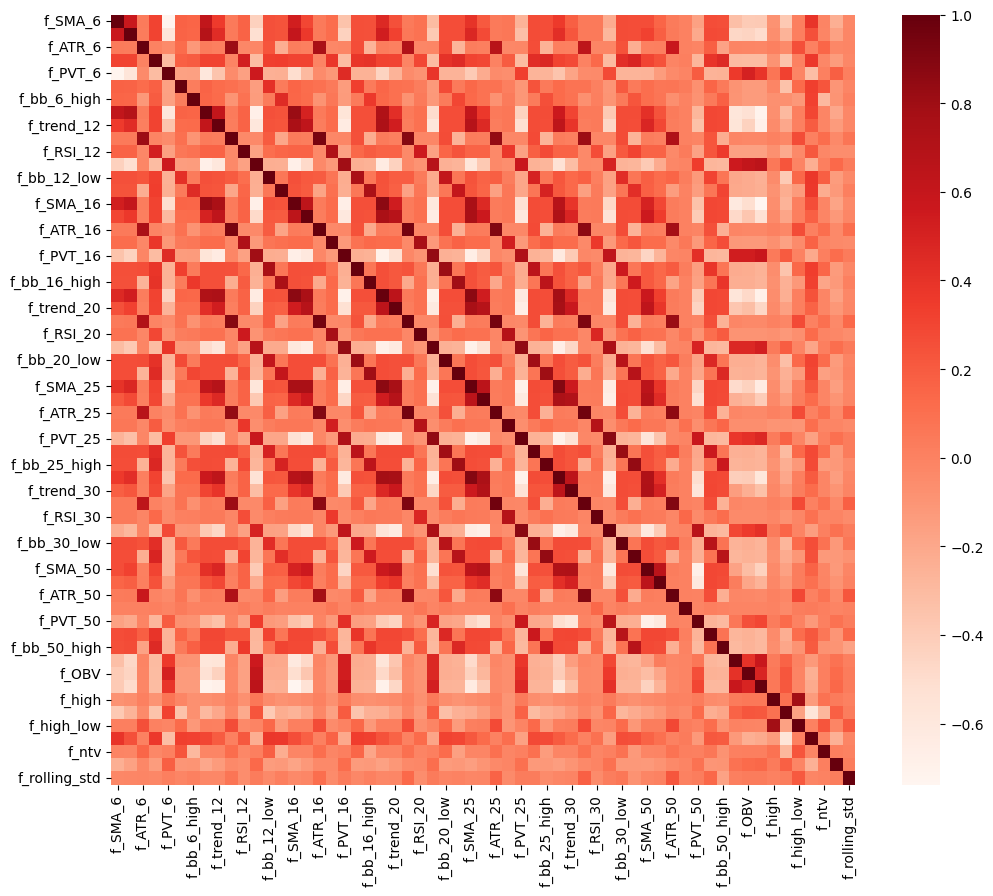

In [54]:
import seaborn as sns
features = [col for col in df if col.startswith('f_')]
plt.figure(figsize=(12,10))
cor = df[features].corr()
sns.heatmap(cor,annot=False, cmap=plt.cm.Reds)
plt.show()